# Imports

In [1]:
# For reading the data
import pandas
import os
import numpy as np

from datetime import datetime
from dateutil import tz

In [2]:
# General plotting commands
from matplotlib.path import Path
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

# pip install numpy --upgrade
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
from cartopy.io.img_tiles import GoogleTiles

In [3]:
# For plotting GPS on map
# Installation: requires most up-to-date numpy
# pip install numpy --upgrade --user
# pip install cartopy --user
# If that fails, install from source: https://scitools.org.uk/cartopy/docs/latest/installing.html#installing

# Helper functions

In [4]:
def get_filenames(path, contains, does_not_contain=['~', '.pyc']):
    '''
    Load all filenames from path that contain the string defined by contains
    '''
    cmd = 'ls ' + '"' + path + '"'
    ls = os.popen(cmd).read()
    all_filelist = ls.split('\n')
    try:
        all_filelist.remove('')
    except:
        pass
    filelist = []
    for i, filename in enumerate(all_filelist):
        if contains in filename:
            fileok = True
            for nc in does_not_contain:
                if nc in filename:
                    fileok = False
            if fileok:
                filelist.append( os.path.join(path, filename) )
    return filelist

In [5]:
def load_GPS_file_to_pandas(filename):
    '''
    Load one GPS .txt file to a pandas dataframe, remove rows without data
    '''
    df = pandas.read_csv(filename, names=['GPS_type', 
                                      'Timestamp',
                                      'Validity_Aok_Vinvalid',
                                      'Latitude',
                                      'N_S',
                                      'Longitude',
                                      'E_W',
                                      'Speed',
                                      'Course_Direction',
                                      'Date_Stamp',
                                      'Variation',
                                      'E_W_copy',
                                      'checksum'])
    
    df = df.iloc[0:-1] # drop last row, which may have corrupt data
    df = df.dropna(subset=['Longitude', 'Latitude'])
    
    df.Longitude = df.Longitude.astype(np.float64)
    df.Latitude = df.Latitude.astype(np.float64)
    df.Timestamp = df.Timestamp.astype(float).astype(int)
    
    return df

In [6]:
def convert_degmin_to_decimal(df):
    '''
    Convert to a more intuitive GPS datatype: decimal (what google maps uses) 
    '''
    longitude_signs = []
    for s in df.E_W:
        if s == 'W':
            longitude_signs.append(-1)
        elif s == 'E':
            longitude_signs.append(1)
        else:
            longitude_signs.append(np.nan)
    df['Longitude_Signs'] = longitude_signs
    
    latitude_signs = []
    for s in df.N_S:
        if s == 'S':
            latitude_signs.append(-1)
        elif s == 'N':
            latitude_signs.append(1)
        else:
            latitude_signs.append(np.nan)
    df['Latitude_Signs'] = latitude_signs

    degrees = np.floor(df.Latitude/100)
    minutes = (df.Latitude/100 - degrees)*100
    decimal = degrees + minutes/60.
    df.Latitude = decimal*df.Latitude_Signs
    
    degrees = np.floor(df.Longitude/100)
    minutes = (df.Longitude/100 - degrees)*100
    decimal = degrees + minutes/60.
    df.Longitude = decimal*df.Longitude_Signs
    
    return df

In [7]:
def interpolate_missing_time_and_date_stamps(df):
    df.Date_Stamp = df.Date_Stamp.astype(float).interpolate(method='linear')
    df.Date_Stamp = df.Date_Stamp.astype(int)
    df.Timestamp = df.Timestamp.astype(float).interpolate(method='linear')
    df.Timestamp = df.Timestamp.astype(int)
    return df

In [8]:
def make_utc_string_time(df):
    str_tstamps = df.Timestamp.values.astype(str)
    S = [s[-2:] for s in str_tstamps]
    M = [s[-4:-2] for s in str_tstamps]
    H = [s[:-4] for s in str_tstamps]

    str_dstamps = df.Date_Stamp.values.astype(str)
    Y = [s[-2:] for s in str_dstamps]
    m = [s[-4:-2] for s in str_dstamps]
    d = [s[:-4] for s in str_dstamps]

    str_utc_time = ['20'+Y[i]+'-'+m[i]+'-'+d[i]+' '+H[i]+':'+M[i]+':'+S[i] for i in range(len(Y))]
    
    df['Timestamp_UTC_str'] = str_utc_time
    
    return df

In [9]:
def convert_utc_to_local_and_epoch_time(df, to_zone='America/Los_Angeles'):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz(to_zone)
    
    Timestamp_Local_str = []
    Timestamp_epoch = []
    for t in df.Timestamp_UTC_str.values:
        utc = datetime.strptime(t, '%Y-%m-%d %H:%M:%S')
        utc = utc.replace(tzinfo=from_zone)
        local = utc.astimezone(to_zone)
        local_str = local.strftime('%Y-%m-%d %H:%M:%S')
        Timestamp_Local_str.append(local_str)
        Timestamp_epoch.append(local.timestamp())
        
    df['Timestamp_Local_str'] = Timestamp_Local_str
    df['Timestamp_epoch'] = Timestamp_epoch
    
    return df

In [10]:
def load_GPS_directory_to_pandas(directory):
    '''
    Load all the GPS txt files in a directory, and convert them to decimal.
    Returns a single pandas dataframe
    '''
    filenames = get_filenames(directory, 'GPS_')
    dfs = [load_GPS_file_to_pandas(filename) for filename in filenames]
    df = pandas.concat(dfs)
    
    df = convert_degmin_to_decimal(df)
    df = interpolate_missing_time_and_date_stamps(df)
    df = make_utc_string_time(df)
    df = convert_utc_to_local_and_epoch_time(df, to_zone='America/Los_Angeles')
    # should sort.. according to timestamps, see: https://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.sort_values.html#pandas.DataFrame.sort_values
    
    return df

# Load data and plot

In [11]:
df = load_GPS_directory_to_pandas('.')
df


,GPS_type,Timestamp,Validity_Aok_Vinvalid,Latitude,N_S,Longitude,E_W,Speed,Course_Direction,Date_Stamp,Variation,E_W_copy,checksum,Longitude_Signs,Latitude_Signs,Timestamp_UTC_str,Timestamp_Local_str,Timestamp_epoch
80,$GPRMC,195357,A,39.539343,N,-119.813267,W,0.059,NaN,70819,NaN,NaN,A*66,-1,1,2019-08-7 19:53:57,2019-08-07 12:53:57,1.565208e+09
81,$GPRMC,195358,A,39.539340,N,-119.813266,W,0.091,NaN,70819,NaN,NaN,A*64,-1,1,2019-08-7 19:53:58,2019-08-07 12:53:58,1.565208e+09
82,$GPRMC,195359,A,39.539349,N,-119.813271,W,0.044,NaN,70819,NaN,NaN,A*60,-1,1,2019-08-7 19:53:59,2019-08-07 12:53:59,1.565208e+09
83,$GPRMC,195400,A,39.539351,N,-119.813273,W,0.23,NaN,70819,NaN,NaN,A*62,-1,1,2019-08-7 19:54:00,2019-08-07 12:54:00,1.565208e+09
84,$GPRMC,195401,A,39.539351,N,-119.813273,W,0.035,NaN,70819,NaN,NaN,A*64,-1,1,2019-08-7 19:54:01,2019-08-07 12:54:01,1.565208e+09
85,$GPRMC,195402,A,39.539354,N,-119.813272,W,0.081,NaN,70819,NaN,NaN,A*65,-1,1,2019-08-7 19:54:02,2019-08-07 12:54:02,1.565208e+09
86,$GPRMC,195403,A,39.539362,N,-119.813274,W,0.013,NaN,70819,NaN,NaN,A*69,-1,1,2019-08-7 19:54:03,2019-08-07 12:54:03,1.565208e+09
87,$GPRMC,195404,A,39.539367,N,-119.813274,W,0.046,NaN,70819,NaN,NaN,A*6B,-1,1,2019-08-7 19:54:04,2019-08-07 12:54:04,1.565208e+09
88,$GPRMC,195405,A,39.539370,N,-119.813275,W,0.038,NaN,70819,NaN,NaN,A*66,-1,1,2019-08-7 19:54:05,2019-08-07 12:54:05,1.565208e+09
89,$GPRMC,195406,A,39.539371,N,-119.813276,W,0.027,NaN,70819,NaN,NaN,A*62,-1,1,2019-08-7 19:54:06,2019-08-07 12:54:06,1.565208e+09


Text(0,0.5,'Latitude')

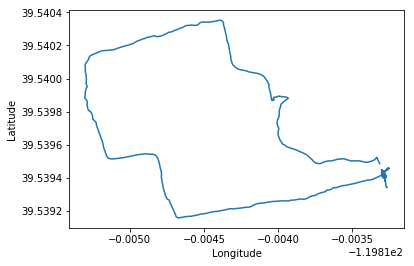

In [12]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(df.Longitude, df.Latitude)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


Text(0,0.5,'Speed, units?')

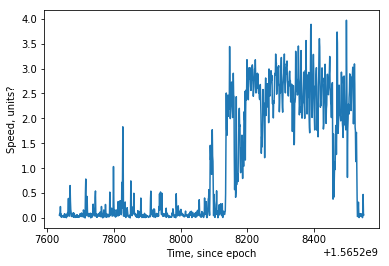

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(df.Timestamp_epoch, df.Speed)
ax.set_xlabel('Time, since epoch')
ax.set_ylabel('Speed, units?')

In [14]:
# We started walking about halfway into the dataset
# So let's restrict the data to that part
df = df[df.Timestamp_epoch > df.Timestamp_epoch.mean()]

In [15]:
mean_latitude = df.Latitude.mean()
mean_longitude = df.Longitude.mean()

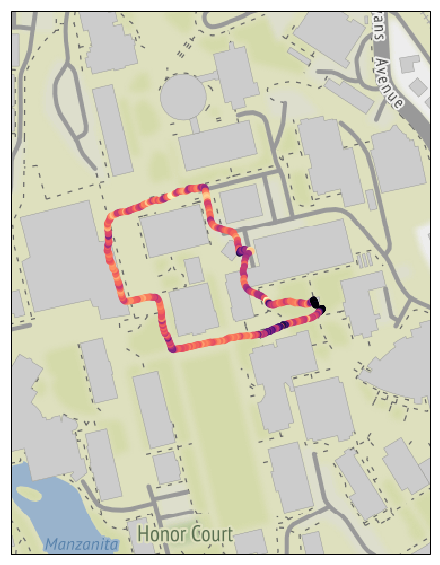

In [16]:
# Terrain Tiles from Stamen

# Define image tiles
tiler = Stamen('terrain')
mercator = tiler.crs

# Create figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=mercator)

# Define the GPS window
ax.set_extent([mean_longitude-0.002, mean_longitude+0.002, mean_latitude-0.002, mean_latitude+0.002], 
              crs=ccrs.PlateCarree())

# Download images with resolution
resolution = 17
ax.add_image(tiler, resolution)

# Plot the GPS tracks
ax.scatter(df.Longitude, df.Latitude, c=df.Speed, cmap='magma', transform=ccrs.Geodetic())

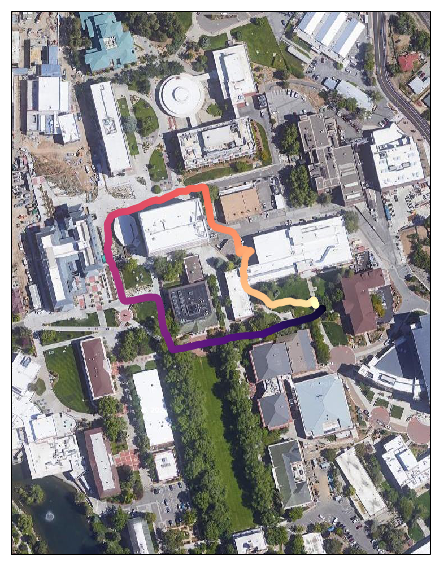

In [17]:
# Satellite Tiles from Google

# Define image tiles
tiler = GoogleTiles(style='satellite')
mercator = tiler.crs

# Create figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=mercator)

# Define the GPS window
ax.set_extent([mean_longitude-0.002, mean_longitude+0.002, mean_latitude-0.002, mean_latitude+0.002], 
              crs=ccrs.PlateCarree())

# Download images with resolution
resolution = 18
ax.add_image(tiler, resolution)

# Plot the GPS tracks
ax.scatter(df.Longitude, df.Latitude, c=df.Timestamp_epoch, cmap='magma', transform=ccrs.Geodetic())

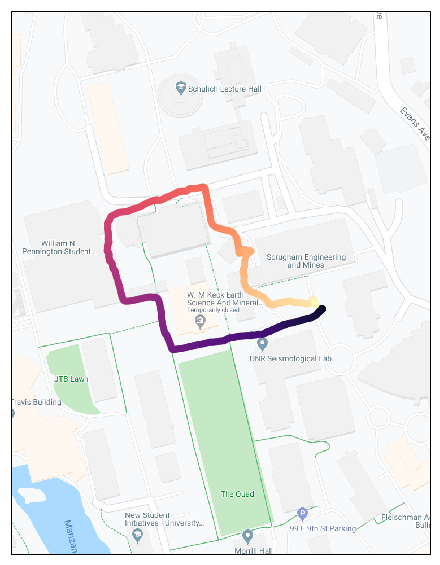

In [18]:
# Street Tiles from Google

# Define image tiles
tiler = GoogleTiles(style='street')
mercator = tiler.crs

# Create figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=mercator)

# Define the GPS window
ax.set_extent([mean_longitude-0.002, mean_longitude+0.002, mean_latitude-0.002, mean_latitude+0.002], 
              crs=ccrs.PlateCarree())

# Download images with resolution
resolution = 18
ax.add_image(tiler, resolution)

# Plot the GPS tracks
ax.scatter(df.Longitude, df.Latitude, c=df.Timestamp_epoch, cmap='magma', transform=ccrs.Geodetic())

### Color of the trajectory encodes time, just as a demonstration of something you can do